In [5]:
import numpy as np
import pandas as pd
from pandas import datetime
import math
from tensorflow.contrib.rnn import LSTMCell, DropoutWrapper, MultiRNNCell
from tensorflow.contrib.layers import fully_connected
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import json
%matplotlib inline

In [6]:
class PRSA_lstm:
    
    def __init__(self, model_to_restore="model/lstm-200"):
    
        self._input_col_cfg = ['pm25_prev', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'NE', 'NW', 'SE', 'cv']
        self._time_steps = 23
        num_units = [64, 64]
        self._X_min, self._X_max = (np.array([  0.00000000e+00,  -4.00000000e+01,  -1.90000000e+01,
                              9.91000000e+02,   4.50000000e-01,   0.00000000e+00,
                              0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
                              0.00000000e+00,   0.00000000e+00]),
                             np.array([  9.94000000e+02,   2.80000000e+01,   4.20000000e+01,
                                      1.04600000e+03,   5.65490000e+02,   2.70000000e+01,
                                      3.60000000e+01,   1.00000000e+00,   1.00000000e+00,
                                      1.00000000e+00,   1.00000000e+00]))
        tf.reset_default_graph()
        
        self._graph = tf.Graph()

        with self._graph.as_default():


            self._Xt = tf.placeholder(shape=[1, self._time_steps, 11], dtype=tf.float32)
            b_size = tf.shape(self._Xt)[0]

            #I do a basic now and look at the graph
            lstm_cells = list()
            for u in range(len(num_units)):
                lstm_cells.append(LSTMCell(num_units=num_units[u], state_is_tuple=True))
                                  
            lstm_cells = MultiRNNCell(lstm_cells, state_is_tuple=True)
            initial_states = lstm_cells.zero_state(b_size, dtype=tf.float32)
            outputs, states = tf.nn.dynamic_rnn(lstm_cells, inputs=self._Xt, initial_state=initial_states)

            self._fc_final = fully_connected(inputs=outputs[:,-1,:], activation_fn=None, num_outputs=1)
            new_saver = tf.train.Saver()
        
        self._sess = tf.Session(graph=self._graph)    
        new_saver.restore(self._sess, model_to_restore)
            
    def _preprocess(self, data, return_df=False):
        assert(np.all(data.columns.values == np.array(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'])))
        
        assert(len(data)==self._time_steps+1)
        assert(np.all(np.isnan(data["pm2.5"].iloc[0:-1])==False))
        #assert(np.isnan(data["pm2.5"].iloc[-1]))
               
        data["pm2.5"] = data["pm2.5"].shift(1)
        data.drop(labels=data.index[0], axis=0,inplace=True)
        assert(np.all(np.isnan(data["pm2.5"])==False))
        data.rename(columns={"pm2.5":"pm25_prev"}, inplace=True)
        data = pd.concat([data, pd.get_dummies(data.cbwd)], axis=1)
        data.drop(labels=["cbwd"], axis=1, inplace=True)
   
      
        cols_to_add = set(self._input_col_cfg) - set(data.columns)
        for c in cols_to_add:
            data[c] = None
        
        data = data[self._input_col_cfg]
        data.fillna(0, inplace=True)
        
        assert(data.shape[0]==self._time_steps)
        if return_df:
            return (data)
        else:
            return ((data.values-self._X_min)/(self._X_max-self._X_min))
        
    
    def predict(self, data):
        X = self._preprocess(data)
        X = np.expand_dims(X, axis=0)
        return(self._sess.run(self._fc_final, {self._Xt:X})[0][0])
     
    def __exit__(self):
        
        self._sess.close()
        tf.reset_default_graph()
        

In [7]:
data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
data["pm25_predicted"] = 0
data = data[np.isnan(data["pm2.5"])==False]

data.index = data.apply(lambda x:datetime(x.year, x.month, x.day, x.hour), axis=1)
data.drop(labels=["year", "month", "day", "hour", "No"], axis=1, inplace=True)

ts = pd.date_range(start=data.index.min(), end=data.index.max(), freq="H")
data = data.reindex(index=ts, method="pad")

In [8]:
m = PRSA_lstm()
#cut off is 35029
data = data.iloc[35029::]

i=0
predicted = 0 
#Do the time series indexing out may be
while i < len(data)-24:
    its = i//((len(data)-24)//100)
    
    data_test = data.drop(labels="pm25_predicted", axis=1).iloc[i:i+24].copy()
    predicted_value = m.predict(data_test)
    data.iat[i+23, np.where(data.columns=="pm25_predicted")[0][0]] = predicted_value
    
    print("\r{}{:103}{}".format("|", "="*its+"%"+str(its), "|"), end=" ")
    i +=1
    
    
    

INFO:tensorflow:Restoring parameters from model/lstm-200


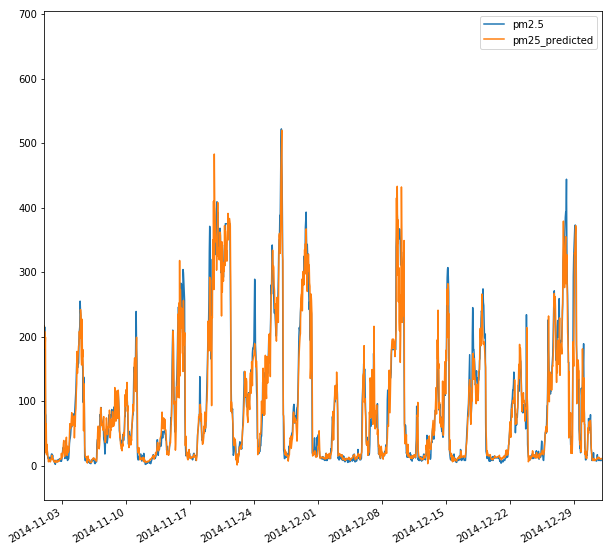

In [22]:
data = data[data.pm25_predicted!=0][["pm2.5", "pm25_predicted"]]
data.plot(figsize=[10, 10])
plt.xlim("2014-11", "2015-01")
plt.show()